 # Team AASE: DeepView
 The aim of this project is to develop a deep learning model that can take ultrasound scan of a pipe that may or may not contain debris, and return a 3D volumetric object.

## Data

In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import ast
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from skimage import measure
from scipy.ndimage import zoom
import re

### Preprocessing 
The 2D slices given to us are stored in `.raw` files, our first objective is to store them as 3D arrays and combined all of them into a singular dataframe that can be utilized for analysis. We first convert the `.raw` files into `.npy` files. 

In [2]:
mesh_data = pd.read_csv('compiled_mesh_data.csv')
mesh_data.head(6) 

#filter out empty rows
# List of problematic scans
invalid_scans = ['scan_053.raw', 'scan_043.raw', 'scan_089.raw']

# Filter out the rows with these scans
mesh_data = mesh_data[~mesh_data['file_name'].isin(invalid_scans)]

In [3]:
def convert_to_float_array(entry):
    # Convert bytes to string if needed
    if isinstance(entry, bytes):
        entry = entry.decode("utf-8")  # Decode bytes to string
    
    # Use regex to find all floating point or integer numbers in the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", entry)
    
    # Convert found numbers to floats and return as a numpy array
    return np.array([float(num) for num in numbers], dtype=np.float32).reshape(-1, 3)  # Reshape if coordinates are (N, 3)

# Ensure all entries in the 'vertices' column are strings
mesh_data['vertices'] = mesh_data['vertices'].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Apply the function to the 'vertices' column
mesh_clean = mesh_data['vertices'].apply(convert_to_float_array)

# Verify the output
print(mesh_clean.head())  # Check the first few parsed rows

0    [[335.0, 411.0, 404.0], [335.0, 411.0, 405.0],...
1    [[301.0, 376.0, 383.0], [301.0, 379.0, 386.0],...
2    [[461.0, 349.0, 299.0], [461.0, 349.0, 300.0],...
3    [[385.0, 342.0, 392.0], [385.0, 342.0, 393.0],...
4    [[481.0, 374.0, 424.0], [481.0, 374.0, 425.0],...
Name: vertices, dtype: object


### Model
First we prepare our training data. We add the vertices values into a voxel grid to create our input tensor. We pass this into our model and then begin trainng.

In [27]:
def vertices_to_voxel_grid(vertices, grid_size=64):
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    
    max_index = grid_size - 1
    indices = vertices.astype(int)
    indices = np.clip(indices, 0, max_index) 

    for idx in indices:
        try:
            voxel_grid[tuple(idx)] = 1.0
        except IndexError:
            print(f"Index {tuple(idx)} out of bounds for grid size {grid_size}. Skipping this vertex.")

    return voxel_grid


voxel_grids = [vertices_to_voxel_grid(vertices) for vertices in mesh_clean]
voxel_grids_np = np.array(voxel_grids, dtype=np.float32) 

Now we begin training our PyTorch model.

In [28]:
train_tensor = torch.tensor(voxel_grids_np).unsqueeze(1)

train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [40]:
class VoxelAutoencoder(nn.Module):
    def __init__(self):
        super(VoxelAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, grid_size//2, grid_size//2, grid_size//2)
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), # Output: (64, grid_size//4, grid_size//4, grid_size//4)
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),# Output: (128, grid_size//8, grid_size//8, grid_size//8)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid to ensure output values are in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [49]:
outputs = model(noisy_input)
print(outputs.requires_grad)  # Should be True


True


In [50]:
def chamfer_distance(pred, target):
    """
    Differentiable Chamfer Distance using continuous voxel values.
    Arguments:
        pred: Tensor of shape (B, 1, grid_size, grid_size, grid_size), predicted voxel grids
        target: Tensor of shape (B, 1, grid_size, grid_size, grid_size), ground truth voxel grids
    Returns:
        chamfer_dist: Scalar, the Chamfer Distance
    """
    pred_points = torch.sigmoid(pred)  # Ensure values are between 0 and 1
    target_points = torch.sigmoid(target)

    # Compute distances from pred to target
    dist1 = torch.sum((pred_points - target_points) ** 2, dim=(2, 3, 4))

    # Compute distances from target to pred
    dist2 = torch.sum((target_points - pred_points) ** 2, dim=(2, 3, 4))

    chamfer_dist = (dist1.mean() + dist2.mean()) / 2
    return chamfer_dist
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for vertices in mesh_clean: 
        input_grid = create_voxel_grid(vertices, grid_size=grid_size)
        input_tensor = torch.tensor(input_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        noisy_input = input_tensor + torch.randn_like(input_tensor) * 0.01

        optimizer.zero_grad()
        outputs = model(noisy_input)  # Shape: (B, 1, grid_size, grid_size, grid_size)

        # Compute Chamfer Distance using voxel grids
        loss = chamfer_distance(outputs, input_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(mesh_clean):.4f}")


Epoch 1/25, Loss: 4794.9797
Epoch 2/25, Loss: 4795.2282
Epoch 3/25, Loss: 4795.2345
Epoch 4/25, Loss: 4794.7154
Epoch 5/25, Loss: 4794.7962
Epoch 6/25, Loss: 4795.1309
Epoch 7/25, Loss: 4795.0083
Epoch 8/25, Loss: 4794.4552
Epoch 9/25, Loss: 4795.2495
Epoch 10/25, Loss: 4794.8978
Epoch 11/25, Loss: 4794.5241
Epoch 12/25, Loss: 4794.9582
Epoch 13/25, Loss: 4794.3729
Epoch 14/25, Loss: 4795.3745
Epoch 15/25, Loss: 4794.2740
Epoch 16/25, Loss: 4795.2057
Epoch 17/25, Loss: 4794.4584
Epoch 18/25, Loss: 4795.0317
Epoch 19/25, Loss: 4794.8046
Epoch 20/25, Loss: 4794.7819
Epoch 21/25, Loss: 4795.0509
Epoch 22/25, Loss: 4794.6481
Epoch 23/25, Loss: 4794.9669
Epoch 24/25, Loss: 4795.0020
Epoch 25/25, Loss: 4794.7692


Here we visualize a slice from our dataset, showing our voxel grid for a given slice.

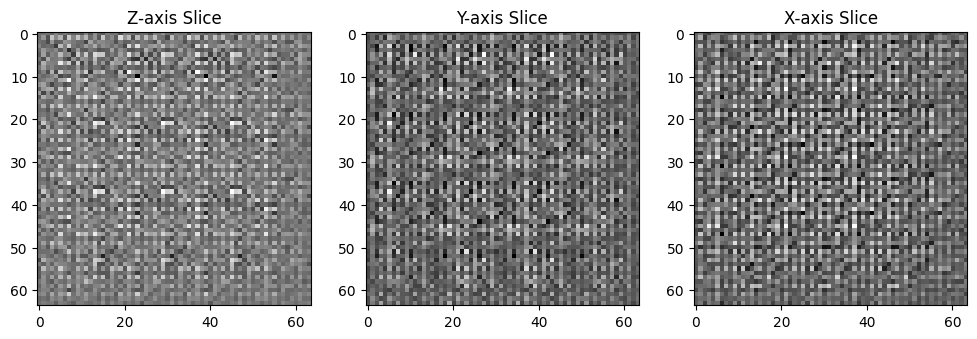

In [51]:
# Get a random sample from the dataset
with torch.no_grad():
    model.eval()
    sample_idx = 49  # Change this to visualize different scans
    input_voxel = train_tensor[sample_idx].unsqueeze(0).to(device)  # Add batch dimension
    reconstructed_voxel = model(input_voxel).squeeze().cpu().numpy()  # Remove batch and channel dims

# Visualize the reconstructed voxel grid along different slices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_voxel[:, :, 32], cmap='gray')  # Slice along Z-axis
plt.title('Z-axis Slice')
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_voxel[:, 32, :], cmap='gray')  # Slice along Y-axis
plt.title('Y-axis Slice')
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_voxel[32, :, :], cmap='gray')  # Slice along X-axis
plt.title('X-axis Slice')
plt.show()

In [52]:
def plot_mesh_from_data(data, threshold=None):
    # Check data range and dynamically set threshold if none is provided
    data_min, data_max = np.min(data), np.max(data)
    if threshold is None:
        threshold = data_min + (data_max - data_min) * 0.05  # Start with 5% of max range

    print(f"Using threshold: {threshold}")
    print(f"Data range: min={data_min}, max={data_max}")

    # Extract vertices and faces using marching cubes
    try:
        verts, faces, _, _ = measure.marching_cubes(data, level=threshold)
    except ValueError as e:
        print(f"Error in marching cubes: {e}")
        return

    # Extract the x, y, z coordinates of the vertices
    x, y, z = verts[:, 0], verts[:, 1], verts[:, 2]
    
    # Plot the 3D mesh with enhanced visibility
    fig = go.Figure(data=[go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color='lightblue',
        opacity=0.7,
        lighting=dict(ambient=0.5, diffuse=0.5, roughness=0.1, specular=0.5)
    )])
    
    # Adjust axis ranges dynamically using `aspectmode='data'`
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X"),
            yaxis=dict(title="Y"),
            zaxis=dict(title="Z"),
            aspectmode='data'  # Adjust aspect ratio based on data range
        ),
        width=800,
        height=800,
        margin=dict(l=50, r=50, b=100, pad=4),
        showlegend=False
    )

    fig.show()


In [60]:
def plot_mesh_from_data(data, threshold=None):
    """
    Plot a 3D mesh from voxel grid data.
    
    Parameters:
    - data: 3D numpy array representing the voxel grid.
    - threshold: Threshold value for the marching cubes algorithm.
    """
    # Check data range and dynamically set threshold if none is provided
    data_min, data_max = np.min(data), np.max(data)
    if threshold is None:
        threshold = data_min + (data_max - data_min) * 0.05  # Default: 5% of range

    print(f"Using threshold: {threshold}")
    print(f"Data range: min={data_min}, max={data_max}")

    # Extract vertices and faces using marching cubes
    try:
        verts, faces, _, _ = measure.marching_cubes(data, level=threshold)
    except ValueError as e:
        print(f"Error in marching cubes: {e}")
        return

    # Extract the x, y, z coordinates of the vertices
    x, y, z = verts[:, 0], verts[:, 1], verts[:, 2]
    
    # Plot the 3D mesh with enhanced visibility
    fig = go.Figure(data=[go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color='lightblue',
        opacity=0.7,
        lighting=dict(ambient=0.5, diffuse=0.5, roughness=0.1, specular=0.5)
    )])
    
    # Adjust layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X", range=[-5, 70]),  # Adjust range based on data
            yaxis=dict(title="Y", range=[-5, 70]),
            zaxis=dict(title="Z", range=[-5, 70]),
            aspectmode='cube'  # Keep aspect ratio equal
        ),
        width=800,
        height=800,
        margin=dict(l=50, r=50, b=100, pad=4),
        showlegend=False
    )

    fig.show()

Now we visualize our models results.

Using threshold: 0.15
Data range: min=0.00868575181812048, max=0.9788681268692017


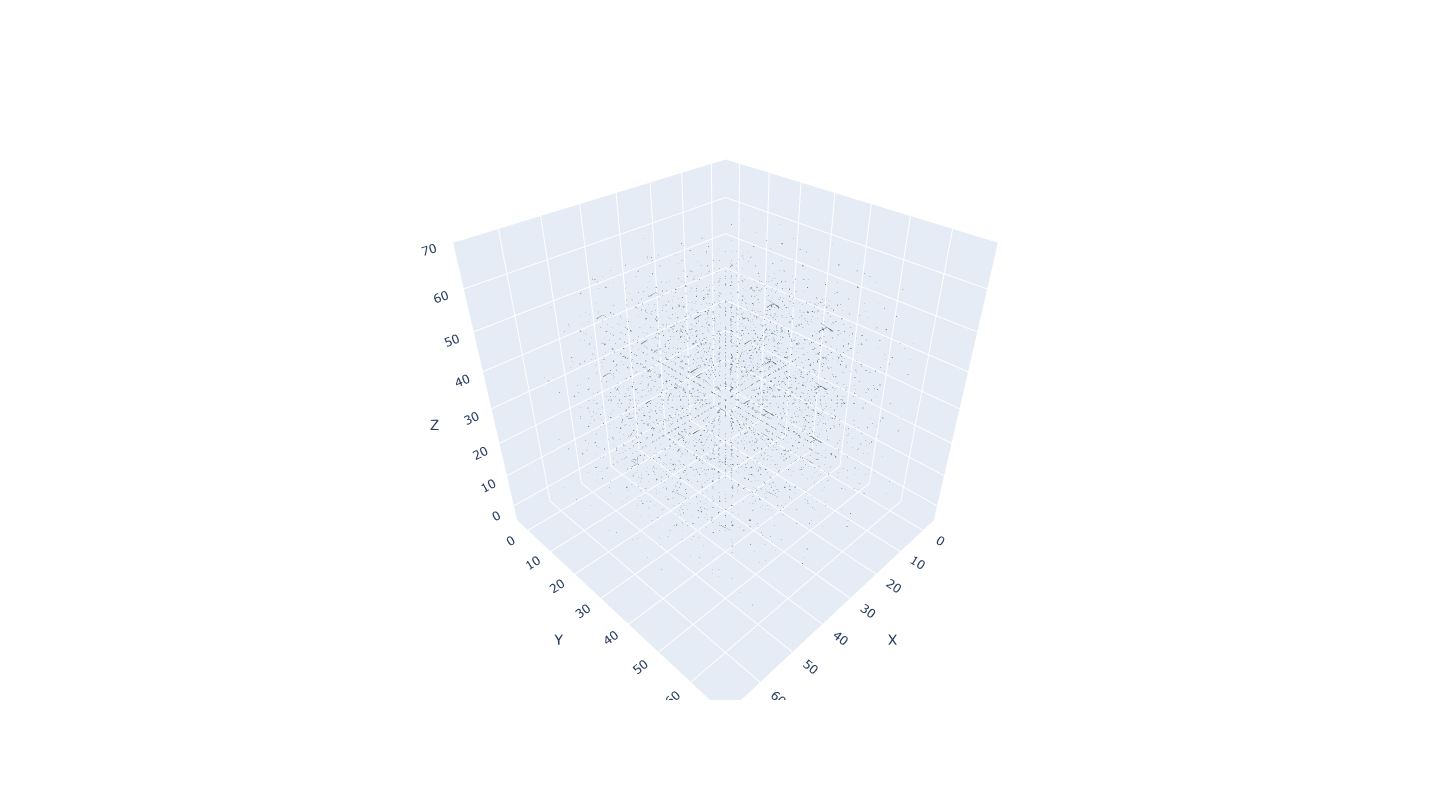

In [61]:
# Ensure reconstructed_voxel is a 3D numpy array from the model's output
with torch.no_grad():
    model.eval()
    sample_idx = 0  # Change this to visualize a different scan
    input_voxel = train_tensor[sample_idx].unsqueeze(0).to(device)  # Add batch dimension
    reconstructed_voxel = model(input_voxel).squeeze().cpu().numpy()  # Remove batch and channel dims

# Plot the reconstructed voxel grid in 3D
plot_mesh_from_data(reconstructed_voxel, threshold=0.15)  # Adjust threshold if needed


In [ ]:

def plot_2d_slices(original_scan, reconstructed_data, slice_index=5):
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    # Original scan X-axis slice (scaled)
    axes[0, 0].imshow(np.squeeze(original_scan[slice_index, :, :]) / 65535, cmap='gray')
    axes[0, 0].set_title("Original X-axis Slice")
    axes[0, 1].imshow(reconstructed_data[slice_index, :, :], cmap='gray')
    axes[0, 1].set_title("Reconstructed X-axis Slice")
    
    # Original scan Y-axis slice (scaled)
    axes[1, 0].imshow(np.squeeze(original_scan[:, slice_index, :]) / 65535, cmap='gray')
    axes[1, 0].set_title("Original Y-axis Slice")
    axes[1, 1].imshow(reconstructed_data[:, slice_index, :], cmap='gray')
    axes[1, 1].set_title("Reconstructed Y-axis Slice")
    
    # Original scan Z-axis slice (scaled)
    axes[2, 0].imshow(np.squeeze(original_scan[:, :, slice_index]) / 65535, cmap='gray')
    axes[2, 0].set_title("Original Z-axis Slice")
    axes[2, 1].imshow(reconstructed_data[:, :, slice_index], cmap='gray')
    axes[2, 1].set_title("Reconstructed Z-axis Slice")
    
    plt.tight_layout()
    plt.show()

#To sid: set the first raw scan here as scan_001 and run the function below
plot_2d_slices(raw_img, reconstructed_tensor, slice_index=5)
